In [198]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scripts.utils import trigonometric_date_encoding, add_seasonality, create_lags, apply_moving_average_for_roc, create_sequences
import os
from dotenv import load_dotenv

In [199]:
# Read in the CSV data
load_dotenv()
APPLE_PATH = str(os.getenv("APPLE_PATH"))

df = pd.read_csv(APPLE_PATH)

In [200]:
df["Date"] = pd.to_datetime(df["Date"], format="%d-%m-%Y")
df = df.sort_values(by="Date")

# Extract the year, month, and day as separate columns
df["Year"] = df["Date"].dt.year
df["Month"] = df["Date"].dt.month
df["Day"] = df["Date"].dt.day
df = df.drop(columns=["Adjusted Close"])

In [201]:
df = add_seasonality(df)

In [202]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10590 entries, 0 to 10589
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   Date                    10590 non-null  datetime64[ns]
 1   Low                     10590 non-null  float64       
 2   Open                    10590 non-null  float64       
 3   Volume                  10590 non-null  int64         
 4   High                    10590 non-null  float64       
 5   Close                   10590 non-null  float64       
 6   Year                    10590 non-null  int32         
 7   Month                   10590 non-null  int32         
 8   Day                     10590 non-null  int32         
 9   Month_Category_Bearish  10590 non-null  float64       
 10  Month_Category_Bullish  10590 non-null  float64       
 11  Month_Category_Normal   10590 non-null  float64       
dtypes: datetime64[ns](1), float64(7), int32(3), in

In [203]:
# Split the data into training and testing sets
train_size = int(len(df) * 0.8)
val_size = int(len(df) * 0.1)
train = df.iloc[:train_size, :]
val = df.iloc[train_size : train_size + val_size, :]
test = df.iloc[train_size + val_size :, :]

In [204]:
train = apply_moving_average_for_roc(dataframe= train,roc_window= 10)
test = apply_moving_average_for_roc(dataframe= test,roc_window= 10)
val = apply_moving_average_for_roc(dataframe= val,roc_window= 10)

In [205]:
train = create_lags(train, 3)
val = create_lags(val, 3)
test = create_lags(test, 3)

In [206]:
train = trigonometric_date_encoding(train)
val = trigonometric_date_encoding(val)
test = trigonometric_date_encoding(test)
train = train.drop(["Date"], axis=1)
val = val.drop(["Date"], axis=1)
test = test.drop(["Date"], axis=1)

In [207]:
train.head()

,Low,Open,Volume,High,Close,Year,Month,Day,Month_Category_Bearish,Month_Category_Bullish,Month_Category_Normal,ROC_0,ROC_1,ROC_2,lag_1,lag_2,lag_3,sin_date,cos_date
0,0.128348,0.128348,469033600,0.128906,0.128348,1980,12,12,0.0,0.0,1.0,0,0,1,0.128348,0.128348,0.128348,-0.433884,-0.900969
1,0.121652,0.122210,175884800,0.122210,0.121652,1980,12,15,0.0,0.0,1.0,0,0,1,0.128348,0.128348,0.128348,0.000000,1.000000
2,0.112723,0.113281,105728000,0.113281,0.112723,1980,12,16,0.0,0.0,1.0,0,0,1,0.121652,0.128348,0.128348,0.781831,0.623490
3,0.115513,0.115513,86441600,0.116071,0.115513,1980,12,17,0.0,0.0,1.0,0,0,1,0.112723,0.121652,0.128348,0.974928,-0.222521
4,0.118862,0.118862,73449600,0.119420,0.118862,1980,12,18,0.0,0.0,1.0,0,0,1,0.115513,0.112723,0.121652,0.433884,-0.900969


In [208]:
excluded_columns = ["sin_date", "cos_date", "Month_Category_Bearish", "Month_Category_Bullish", "Month_Category_Normal"]
features_to_standardize = [column for column in train.columns if column not in excluded_columns]


# Calculate the mean and standard deviation only for the required columns
train_mean = train[features_to_standardize].mean()
train_std = train[features_to_standardize].std()

# Standardize only the required columns in the train, validation, and test sets
train[features_to_standardize] = (train[features_to_standardize] - train_mean) / train_std
val[features_to_standardize] = (val[features_to_standardize] - train_mean) / train_std
test[features_to_standardize] = (test[features_to_standardize] - train_mean) / train_std

In [209]:
features_to_standardize

['Low',
 'Open',
 'Volume',
 'High',
 'Close',
 'Year',
 'Month',
 'Day',
 'ROC_0',
 'ROC_1',
 'ROC_2',
 'lag_1',
 'lag_2',
 'lag_3']

In [210]:
X_train, y_train = create_sequences(train, 5)
X_val, y_val = create_sequences(val, 5)
X_test, y_test = create_sequences(test, 5)

In [211]:
X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

((8466, 5, 19), (8466,), (1053, 5, 19), (1053,), (1053, 5, 19), (1053,))

In [212]:
import tensorflow as tf
from tensorflow.keras import layers as tfkl
from tensorflow.keras.models import Model as tfkModel

def build_simple_LSTM_regressor(input_shape, output_units=1):
    # Build the neural network layer by layer
    input_layer = tfkl.Input(shape=input_shape, name='Input')

    # LSTM layer
    lstm = tfkl.LSTM(16, activation='leaky_relu', return_sequences=True)(input_layer)
    lstm = tfkl.LSTM(16, activation='leaky_relu')(lstm)

    # Output layer for regression
    output_layer = tfkl.Dense(output_units)(lstm)  # Single unit for regression output

    # Connect input and output through the Model class
    model = tfkModel(inputs=input_layer, outputs=output_layer, name='Simple_LSTM_regressor')

    # Compile the model
    model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

    # Return the model
    return model

# Assuming input_shape is (5, n_features)
input_shape = (X_train.shape[1], X_train.shape[2])  
output_units = 1

# Build and compile the model
model = build_simple_LSTM_regressor(input_shape, output_units)
model.summary()


# Train the model
history = model.fit(
x=X_train,
y=y_train,
batch_size=64,
validation_data=(X_val, y_val),
epochs=50,
callbacks=[
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=10, restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', mode='min', patience=5, factor=0.5, min_lr=1e-5)
]
).history


Model: "Simple_LSTM_regressor"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 5, 19)]           0         
                                                                 
 lstm_20 (LSTM)              (None, 5, 16)             2304      
                                                                 
 lstm_21 (LSTM)              (None, 16)                2112      
                                                                 
 dense_10 (Dense)            (None, 1)                 17        
                                                                 
Total params: 4433 (17.32 KB)
Trainable params: 4433 (17.32 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/50
133/133 [==============================] - 3s 5ms/step - loss: 0.2273 - mae: 0.2709 - val_loss: 1.8586 - val_mae: 1.0319 - lr: 0.001

In [213]:
test_loss = model.evaluate(X_test, y_test, verbose=1)

33/33 [==============================] - 0s 2ms/step - loss: 2.2010 - mae: 1.0810


33/33 [==============================] - 0s 1ms/step


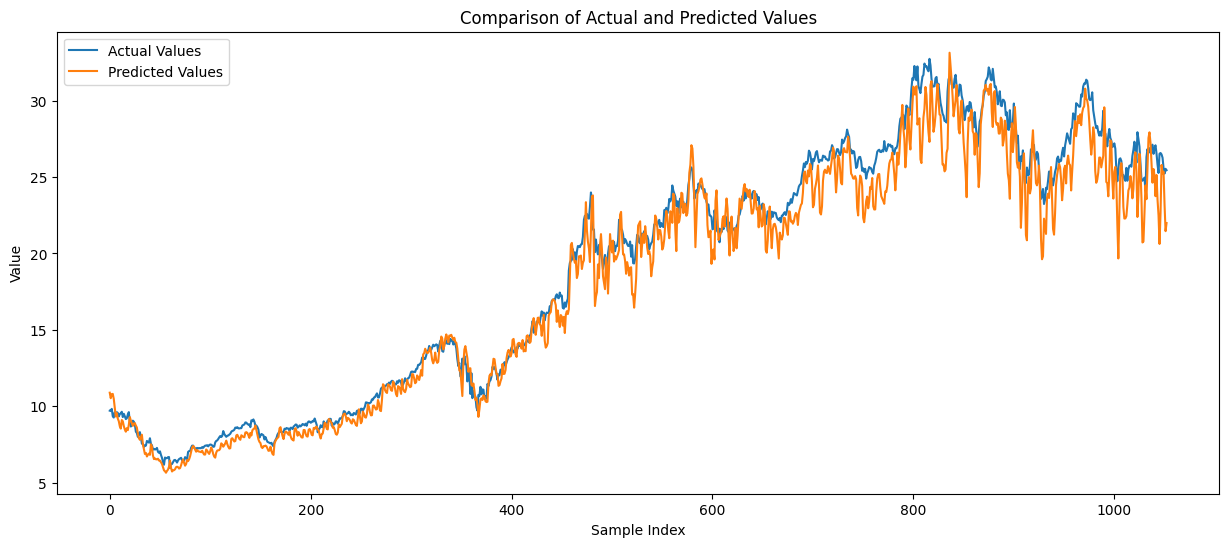

In [214]:
y_pred = model.predict(X_test)
# Plotting
plt.figure(figsize=(15, 6))
plt.plot(y_test, label='Actual Values')
plt.plot(y_pred, label='Predicted Values')
plt.title('Comparison of Actual and Predicted Values')
plt.xlabel('Sample Index')
plt.ylabel('Value')
plt.legend()
plt.show()

33/33 [==============================] - 0s 2ms/step


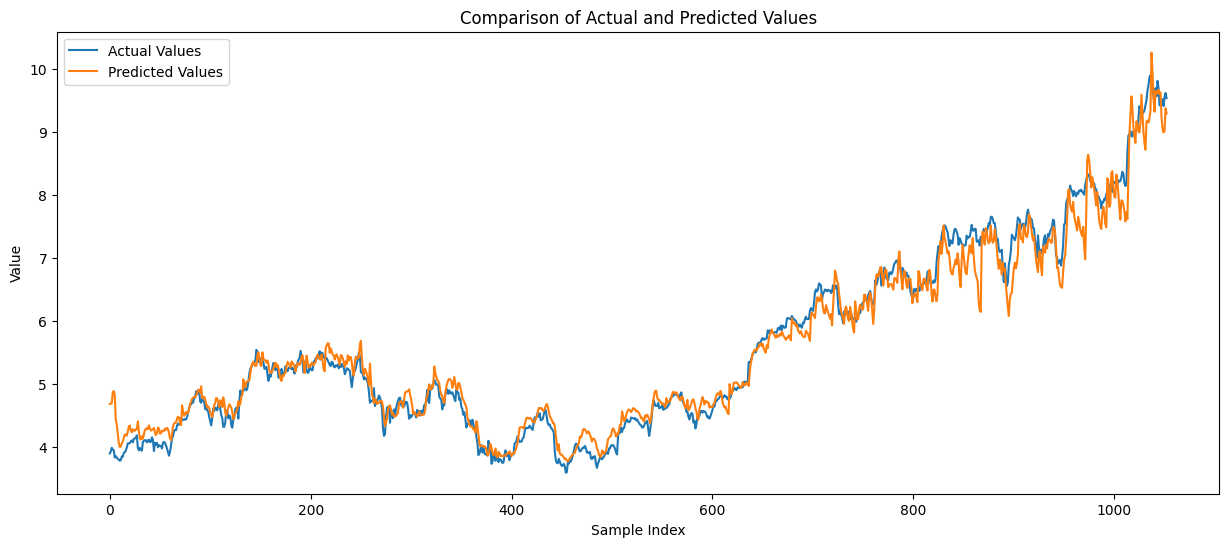

In [215]:
y_pred = model.predict(X_val)
# Plotting
plt.figure(figsize=(15, 6))
plt.plot(y_val, label='Actual Values')
plt.plot(y_pred, label='Predicted Values')
plt.title('Comparison of Actual and Predicted Values')
plt.xlabel('Sample Index')
plt.ylabel('Value')
plt.legend()
plt.show()

265/265 [==============================] - 0s 1ms/step


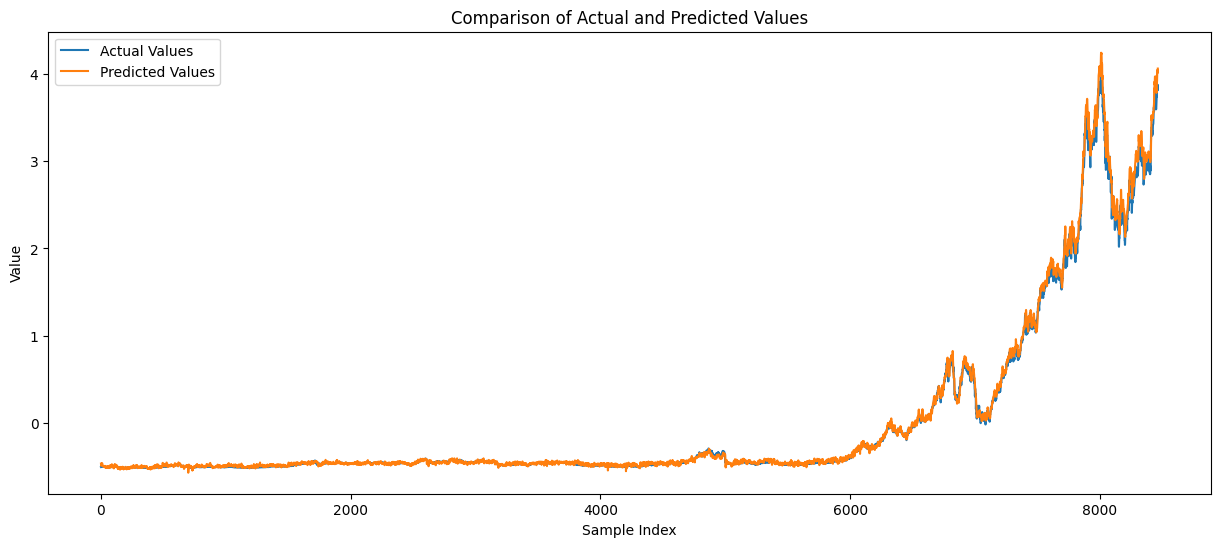

In [216]:
y_pred = model.predict(X_train)
# Plotting
plt.figure(figsize=(15, 6))
plt.plot(y_train, label='Actual Values')
plt.plot(y_pred, label='Predicted Values')
plt.title('Comparison of Actual and Predicted Values')
plt.xlabel('Sample Index')
plt.ylabel('Value')
plt.legend()
plt.show()

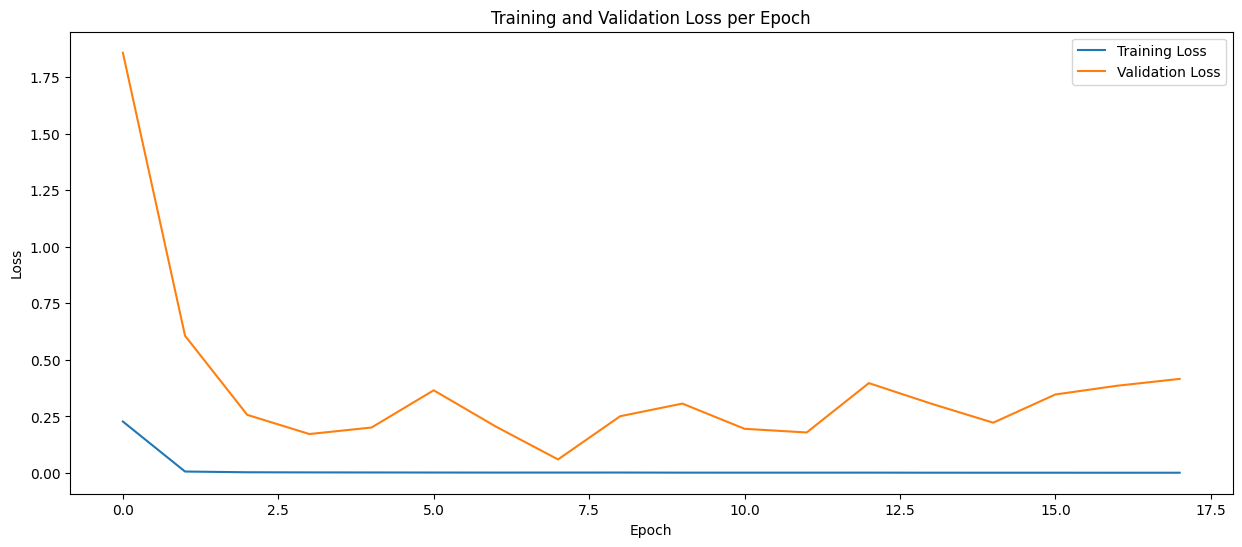

In [217]:
import matplotlib.pyplot as plt

# Extracting loss data from the history object
train_loss = history['loss']
val_loss = history['val_loss']

# Number of epochs actually completed (may be less than 50 due to early stopping)
epochs = range(len(train_loss))

# Plotting the loss per epoch
plt.figure(figsize=(15, 6))
plt.plot(epochs, train_loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.title('Training and Validation Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()
